# Code embedding using Keras

In [ ]:
#TODO add keras history plot

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
font = {'weight': 'bold', 'size': 20}
plt.rc('font', **font)

## Load data

In [73]:
dataframe = pd.read_json('../../data/train.json')

In [74]:
dataframe.head(2)

,data_source,label,file_name,is_header,content
0,crypto-library,1,/Users/red/Documents/CP/crypto_code_detection/...,False,/* primegen.c - prime number generator\n * Cop...
1,others,0,c_impl.c,False,"#include <stdio.h>\n\nfloat f (char *str, int ..."


In [75]:
'{:,}'.format(len(dataframe))

'9,136'

Target value:

In [76]:
dataframe.label.value_counts()

0    8045
1    1091
Name: label, dtype: int64

Remove comments:

Grab docs (code submissions) and labels (correct or not):

In [77]:
import re

def remove_comments(string):
    # remove all occurrences streamed comments (/*COMMENT */) from string
    string = re.sub(re.compile(r"/\*.*?\*/",re.DOTALL ) , "" , string) 
    # remove all occurrence single-line comments (//COMMENT\n ) from string
    string = re.sub(re.compile(r"//.*?\n" ) , "" , string)
    return string


def get_docs_and_labels(df):
    _docs = []
    _labels = []
    for index in df.index:
        # Program
        
        code = remove_comments(
            df.at[index, 'content']
        )
        _docs.append(code)
        # Label
        label = int(df.at[index, 'label'])
        _labels.append(label)
    return _docs, _labels

In [78]:
docs, labels = get_docs_and_labels(dataframe)

In [79]:
'{:,}'.format(len(docs))

'9,136'

In [80]:
for item in dataframe.loc[1:5,'content'].iteritems():
    print(item)

(1, '#include <stdio.h>\n\nfloat f (char *str, int n) {\n  printf ("str is: %s\\nn is: %d\\n", str, n);\n  return n*n;\n}\n')
(2, '#include <iostream>\n\nusing namespace std;\n\nlong long gcd(long long x, long long y)\n{\n\tif (x % y == 0) return y;\n\telse\n\t\treturn gcd(y, x % y);\n}\n\nint main()\n{\n\n\tfreopen("A-large.in", "r", stdin);\n\tfreopen("A-large.out", "w", stdout);\n\tint T;\n\tcin >> T;\n\tfor (int tt = 1 ; tt <= T; tt++)\n\t{\n\t\tstring s;\n\t\tcin >> s;\n\t\tint l = s.length();\n\t\tlong long numb[2];\n\t\tnumb[0] = numb[1] = 0;\n\t\tint now = 0;\n\t\tfor (int i = 0 ; i < l ; i++)\n\t\t{\n\t\t\tif (s[i] == \'/\') now++;\n\t\t\telse\n\t\t\t{\n\t\t\t\tnumb[now] = numb[now] * 10 + (long long)(s[i] - \'0\');\n\t\t\t}\n\t\t}\n\n\t\tint ans = 0;\n\n\t\tlong long ggcd = gcd(numb[0], numb[1]);\n\t\tnumb[0] /= ggcd;\n\t\tnumb[1] /= ggcd;\n\n\t\tlong long now_f = numb[1];\n\n\t\twhile (now_f != 1)\n\t\t{\n\t\t\tif (now_f % 2 != 0)\n\t\t\t{\n\t\t\t\tans = -1;\n\t\t\t\tbreak;\

## Tokenize code and generate sequences

In [81]:
import os
#To ignore the warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.text import Tokenizer

In [82]:
#We set the size of the vocabulary
NUM_WORDS = 10000

In [83]:
tokenizer = Tokenizer(num_words=NUM_WORDS, 
                     filters='\t\n,', 
                     lower=True, 
                     split=' ', 
                     char_level=False)

In [84]:
tokenizer.fit_on_texts(docs)

In [85]:
# Size of the vocabulary
len(tokenizer.word_index) 

954951

In [86]:
# document_count: an integer count of the total number of documents that were used to fit the Tokenizer.
'Number docs: {:,}'.format(tokenizer.document_count)

'Number docs: 9,136'

In [87]:
# Number of occurences of if in the dataset
tokenizer.word_counts['if'] # index

100404

In [88]:
# word_docs: a dictionary of words and how many documents each appeared in.
tokenizer.word_docs['if']

4831

In [89]:
sequences = tokenizer.texts_to_sequences(docs)

Let's look at the length distribution of the sequences to know what max size to choose

In [90]:
len_seqs = [len(s) for s in sequences]
np.mean(len_seqs), np.std(len_seqs), np.max(len_seqs)

(498.305823117338, 2955.3337341199535, 153266)

The mean is at 600 but the standard deviation is much bigger

In [91]:
MAX_LENGTH = 1000

Dictionary to transform a vector back to the program:

In [92]:
id_to_word = { v: k for k, v in tokenizer.word_index.items() }

In [93]:
id_to_word[1]

'='

In [94]:
[id_to_word[index] for index in sequences[0]][0:10]

['#include',
 '<config.h>',
 '#include',
 '<stdio.h>',
 '#include',
 '<stdlib.h>',
 '#include',
 '<string.h>',
 '#include',
 '<errno.h>']

Pad documents:

In [95]:
from keras.preprocessing.sequence import pad_sequences
# pad documents
padded_docs = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

In [96]:
padded_docs[0][0:10]

array([  21, 8986, 1927,    1,   48, 1927,   42,   63,   28, 1927],
      dtype=int32)

## Defining the model

In [97]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers.embeddings import Embedding

#We add the epsilon to avoid any error in the function

def precision_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def recall_(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f2(y_true, y_pred):
    
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 5*((precision*recall)/(4*precision+recall+K.epsilon()))

In [98]:
# define the model
model = Sequential()
model.add(Embedding(NUM_WORDS, 50, input_length=MAX_LENGTH))
model.add(Flatten())
model.add(Dropout(rate=0.3))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['acc', f1,f2,precision_,recall_])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 50)          500000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 50001     
Total params: 550,001
Trainable params: 550,001
Non-trainable params: 0
_________________________________________________________________
None


In [99]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
    acc = history.history['recall_']
    val_acc = history.history['val_recall_']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(len(acc))

    plt.title('Training and validation recall')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.savefig('../code_embedding/plots/training_recall.png')

    _ = plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('../code_embedding/plots/training_loss.png')

In [100]:
from sklearn.model_selection import train_test_split

indices = np.arange(padded_docs.shape[0])

X_train, X_test, y_train, y_test,train_idx, test_idx = train_test_split(padded_docs, labels,indices, 
                                                    test_size=0.2, random_state=0,
                                                    stratify=labels)

In [101]:
#Checking the indexing
(X_test[0] == padded_docs[test_idx[0]]).all()

True

In [102]:
# fit the model

history = model.fit(X_train, 
          y_train,
          epochs=5,
          validation_data=(X_test,y_test))

Train on 7308 samples, validate on 1828 samples
Epoch 1/5
7308/7308 [==============================] - 46s 6ms/step - loss: 0.2061 - acc: 0.9268 - f1: 0.4796 - f2: 0.4469 - precision_: 0.6133 - recall_: 0.4321 - val_loss: 0.1021 - val_acc: 0.9650 - val_f1: 0.8293 - val_f2: 0.8039 - val_precision_: 0.9175 - val_recall_: 0.7948
Epoch 2/5
7308/7308 [==============================] - 35s 5ms/step - loss: 0.0653 - acc: 0.9796 - f1: 0.8495 - f2: 0.8378 - precision_: 0.8915 - recall_: 0.8347 - val_loss: 0.0875 - val_acc: 0.9639 - val_f1: 0.8269 - val_f2: 0.7812 - val_precision_: 0.9542 - val_recall_: 0.7574
Epoch 3/5
7308/7308 [==============================] - 35s 5ms/step - loss: 0.0367 - acc: 0.9888 - f1: 0.9275 - f2: 0.9141 - precision_: 0.9615 - recall_: 0.9072 - val_loss: 0.0788 - val_acc: 0.9705 - val_f1: 0.8631 - val_f2: 0.8380 - val_precision_: 0.9433 - val_recall_: 0.8275
Epoch 4/5
7308/7308 [==============================] - 35s 5ms/step - loss: 0.0256 - acc: 0.9922 - f1: 0.9394 - 

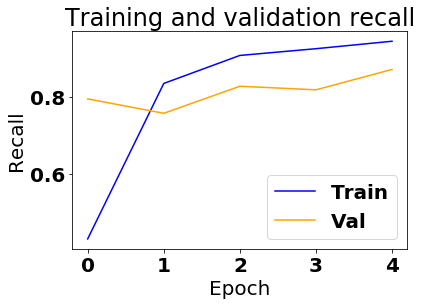

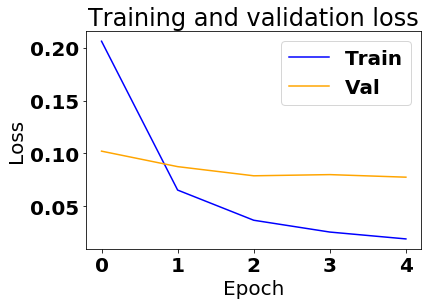

In [103]:
plot(history)

In [104]:
# evaluate the model
word_loss, word_accuracy, word_f1,word_f2, word_precision, word_recall = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f, F1: %f, F2: %f, precision: %f, recall: %f' % (word_accuracy * 100, word_f1 * 100, word_f2 * 100, word_precision*100, word_recall*100))

1828/1828 [==============================] - 0s 98us/step
Accuracy: 97.374179, F1: 87.721708, F2: 86.993035, precision: 91.863428, recall: 87.100135


In [ ]:
word_score = {
    'accuracy': word_accuracy,
    'F1': word_f1,
}
embeddings_scores = { 'Word': word_score }

In [ ]:
# Embedding Layer
embedding_layer = model.layers[0]
embeddings = embedding_layer.get_weights()[0]
print('Embedding Layer shape:', embeddings.shape)

In [ ]:
embeddings[0]

In [ ]:
np.save('../code_embedding/embedding/word_embeddings', embeddings)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)
print('PCA explained variance ratio:', pca.explained_variance_ratio_, 'Total:', sum(pca.explained_variance_ratio_))

In [ ]:
def get_top_words(tokenizer, N=50):
    
    return [word for word, occurrences in sorted(tokenizer.word_counts.items(), key=lambda t: t[1], reverse=True)[:N]]

In [ ]:
top_words = get_top_words(tokenizer)

In [ ]:
def plot_embeddings(low_dim_embs, id_to_word, top_words,id_plot, figsize=(8, 8)):

    plt.figure(figsize=figsize, dpi=100)
    #ax = plt.axes()
    #ax.yaxis.set_major_locator(plt.NullLocator())
    #ax.xaxis.set_major_locator(plt.NullLocator())
    i = 0
    while i < len(low_dim_embs):

        if i in id_to_word:
            
            x, y = low_dim_embs[i, :]
            word = id_to_word[i]

            if word in top_words:
                plt.scatter(x, y, color='b')
                plt.annotate(word,
                            xy=(x, y),
                            xytext=(5, 2),
                            textcoords='offset points',
                            ha='right',
                            va='bottom',
                            fontsize=14)
                plt.title("Embedding projected on PCA space")
        
        i += 1
    plt.savefig('../code_embedding/plots/pca_{}.png'.format(id_plot))

In [ ]:
plot_embeddings(principal_components, id_to_word, top_words,id_plot=0, figsize=(18, 18))

In [ ]:
plot_embeddings(principal_components, id_to_word, get_top_words(tokenizer, 20), id_plot=1)

Measure the distance between vectors:

In [ ]:
from scipy.spatial.distance import euclidean, cosine

def get_vector_distance(embeddings, tok, word1, word2):
    
    return euclidean(embeddings[tok.word_index[word1]], 
                     embeddings[tok.word_index[word2]])
    
def get_vector_cosine_distance(embeddings, tok, word1, word2):
    
    return cosine(embeddings[tok.word_index[word1]], 
                  embeddings[tok.word_index[word2]])

Cosine similarity:

In [ ]:
get_vector_cosine_distance(embeddings, tokenizer, 'x', 'y')

In [ ]:
get_vector_cosine_distance(embeddings, tokenizer, '<<', '=')

In [ ]:
get_vector_cosine_distance(embeddings, tokenizer, '+', '-')

In [ ]:
get_vector_cosine_distance(embeddings, tokenizer, '(', ')')

In [ ]:
get_vector_cosine_distance(embeddings, tokenizer, '{', '}')

Euclidean distance:

In [ ]:
get_vector_distance(embeddings, tokenizer, '<<', '>>')

In [ ]:
get_vector_distance(embeddings, tokenizer, 'x', 'y')

In [ ]:
get_vector_distance(embeddings,tokenizer, 'if', 'elif')

In [ ]:
get_vector_distance(embeddings, tokenizer, 'elif', 'else:')

In [ ]:
get_vector_distance(embeddings, tokenizer, '+', '-')

In [ ]:
get_vector_distance(embeddings, tokenizer, 'for', 'while')

## More complex architecture

In [ ]:
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPooling1D
from sklearn.metrics import f1_score

model = Sequential()
model.add(Embedding(NUM_WORDS, 50, input_length=MAX_LENGTH))
model.add(Conv1D(32, 15, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(32,15, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(32,10, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Conv1D(32,10, strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['acc', f1,f2,precision_,recall_])

print(model.summary())
                    

# Result QA

In [105]:
y_pred = model.predict(X_test)

In [106]:
super_threshold_indices_1 = y_pred >= 0.5
super_threshold_indices_0 = y_pred < 0.5
y_pred[super_threshold_indices_1] = 1
y_pred[super_threshold_indices_0] = 0
y_pred = y_pred.reshape(y_pred.shape[0])

In [107]:
y_false = np.where(y_pred != y_test)[0]

In [108]:
y_false.shape

(48,)

In [109]:
sources = []
for elem in y_false:
    sources.append(dataframe.loc[test_idx[elem],'data_source'])
    print(dataframe.loc[test_idx[elem],:])
    print(dataframe.loc[test_idx[elem],'file_name'])
    print('------')

data_source                                  crypto-competitions
label                                                          1
file_name                                      libpolypasshash.c
is_header                                                  False
content        /*\n * This file is Copyright Santiago Torres ...
Name: 3708, dtype: object
libpolypasshash.c
------
data_source                                       crypto-library
label                                                          1
file_name      /Users/red/Documents/CP/crypto_code_detection/...
is_header                                                   True
content        /*\n * Copyright 1995-2016 The OpenSSL Project...
Name: 2527, dtype: object
/Users/red/Documents/CP/crypto_code_detection/data/crypto-library/files/open_ssl/des/spr.h
------
data_source                                       crypto-library
label                                                          1
file_name      /Users/red/Documents/CP/crypto

In [110]:
print(sources.count("others"))
print(sources.count("crypto-competitions"))
print(sources.count("crypto-library"))
print(sources.count("code-jam"))

20
13
15
0


In [111]:
header_count = 0
header_0 = 0
header_1 = 0
for elem in y_false:
    if(dataframe.loc[test_idx[elem],'is_header']):
        header_count += 1
        if(dataframe.loc[test_idx[elem],'label']==1):
            header_1 += 1
        else:
            header_0 += 1
print(header_count)
print(header_0)
print(header_1)

18
7
11
